# Notebook 2: Classification with Neural Networks

**Authors:** Kenny Choo, Mark H. Fischer, Eliska Greplova

Adaptation for Summer School: ML in Quantum Physics and Chemistry (24.08.-03.09.2021, Warsaw) by Anna Dawid (e.g., introduction to ML libraries, hyperparameters)

Adaptation for a Spring School on Theoretical and Computational Foundations of Quantum Technologies 2023 by Ilya Sinayskiy

## Import of the first ML library!
There are various libraries useful for ML practitioners. Among the most popular are Tensorflow (with Keras) and PyTorch. Both are pretty competitive with each other, so basically both offer the same functionalities [[source]](https://www.imaginarycloud.com/blog/pytorch-vs-tensorflow/).
- **Tensorflow** is a Python numerical library (created by the Google Brain team) with many methods being in fact high-performance C++ binaries. It can be accelerated in the Google Colaboratory by choosing TPU (Tensor Programming Units). Keras is the high-level API of TensorFlow 2, so a kind of user-friendly overlay which simplifies many operations.
- **PyTorch** is a Python library created by Facebook AI Research Lab. Before Tensorflow 2.0, PyTorch strength was a little different way of storing and building ML models, which allowed easier interaction with the models' internals. But Tensorflow 2.0 adapted to that and now the main difference is a little easier debugging of a PyTorch code than Tensorflow one.

Fun fact to confuse you even more: Keras API used to build ML models in Tensorflow looks very similar to the PyTorch way of building ML models ;)

In [2]:
# Tensorflow import
import tensorflow as tf
from tensorflow import keras

# Helper Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

print(tf.__version__)

2.14.0


In this notebook we will repeat the exercise from the notebook `01_Unsupervised_learning` on using data analysis to try to identify different phases of matter. We have seen that sometimes clustering can be really powerful tool, but sometimes it does not work too well. Here, we will learn how to accomplish the same task using neural networks and see if they can do better.

# Ising Spin Configuration Classification


The Ising model is given by the (classical) Hamiltonian:

\begin{align}
H(\boldsymbol{\sigma}) = -\sum_{<ij>} \sigma_{i}\sigma_{j},
\end{align}
where the spins $\sigma_{i} \in \lbrace -1, 1 \rbrace$ are binary variables living on the vertices of a square lattice and the sum is taken over nearest neighbours $<ij>$. 
  
At a given temperature $\beta = 1/T$, the probability of a configuration $\sigma$ is given by the Boltzmann distribution
  
\begin{align}
  P(\boldsymbol{\sigma}) = \frac{e^{-\beta H(\boldsymbol{\sigma})}}{Z},
 \end{align}
  
  where $Z$ is the partition function. This model exhibits a phase transition from the ferromagnetic phase at low tempertures to a paramagnetic phase at high temperatures. The transition temperature is $T_c \approx 2.2692$.
  
  **Task**
 
1.   Classify the ferromagnetic versus the paramagnetic phase of the Ising model
2.   Find the transition temperature
  
**Dataset**: Monte Carlo generated configurations on a 30x30 square lattice. The configuration are labelled by temperature.




## Step 1: Import data and analyze the data shape

The folder `Ising` contains Monte Carlo generated Ising configurations on the two-dimensional lattice. The data set is divided into training and test parts and corresponding label files containing the temperature, $T$, of each Monte Carlo sample.

In [3]:
N = 30 # linear dimension of the lattice 

folder = "Ising_data"

ising_training_configs = np.load(folder + "/ising_training_configs_{0}x{0}.npy".format(N))
ising_training_labels = np.load(folder + "/ising_training_labels_{0}x{0}.npy".format(N))
ising_test_configs = np.load(folder + "/ising_test_configs_{0}x{0}.npy".format(N))
ising_test_labels = np.load(folder + "/ising_test_labels_{0}x{0}.npy".format(N))

print('train_images.shape =', ising_training_configs.shape)
print('train_labels.shape =', ising_training_labels.shape)
print('test_images.shape =', ising_test_configs.shape)
print('test_labels.shape =', ising_test_labels.shape)

train_images.shape = (1000, 30, 30)
train_labels.shape = (1000,)
test_images.shape = (1000, 30, 30)
test_labels.shape = (1000,)


## Step 2: Prepare data

At the moment, our configurations are labelled by their temperature. Since we want to learn to classify the two phases, we need to label our data by 'Ordered' (label=0) vs 'Disordered (label=1).

Let us assume that we know $1.5=T_{low}<T_{c}< T_{high} = 2.5$. Then we exclude all the data between $T_{low}$ and $T_{high}$. We label all configurations below $T_{low}$ with '0' and all those above $T_{high}$ with '1'.

In [4]:
# Assign labels according to the temperature
T_low = 1.5
T_high = 2.5

# Start with training data
train_images = []
train_labels = []

for i, label in enumerate(ising_training_labels):
    if label < T_low:
        train_images.append(ising_training_configs[i])
        train_labels.append(0)
    if label > T_high:
        train_images.append(ising_training_configs[i])
        train_labels.append(1)

# Now you should have smaller training data set, check it
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print(train_images.shape)

(600, 30, 30)


In [5]:
# Do the same with test data
test_images = []
test_labels = []
for i, label in enumerate(ising_test_labels):
    if label < T_low:
        test_images.append(ising_test_configs[i])
        test_labels.append(0)
    if label > T_high:
        test_images.append(ising_test_configs[i])
        test_labels.append(1)
# Again, less test data
test_images = np.array(test_images)
test_labels = np.array(test_labels)

## Step 3: Setup the model

Specifications of our model: 

*  Our model takes in a 30 by 30 array
*  And outputs a 2-dimensional vector

The 2-dimensional vector gives the models prediction for whether the system is ferromagnetic (i.e., $T$ < $T_c$) or paramagnetic ($T$ > $T_c$).

The model's prediction is given by the index with the largest value, i.e. argmax(output)

There are two ways to create models within Keras.

1.   Sequential Model
2.   Model class with the functional API

In both methods, the basic building block is the layer. A layer takes some input tensor and applies some transformation and returns an output tensor.

First let us explore the sequential model.

In [6]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(30, 30)))
model.add(keras.layers.Dense(32, activation=tf.nn.relu))
model.add(keras.layers.Dense(2, activation=tf.nn.softmax))

# We can also print a summary of our model by
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 900)               0         
                                                                 
 dense (Dense)               (None, 32)                28832     
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 28898 (112.88 KB)
Trainable params: 28898 (112.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Hyperparameters

Why 32 neurons? Good question! No one knows exactly ;) Building a ML model is a combination of educated guess, good practices, and pure luck. General rule - the simpler model (the smaller number of parameters), the better. We will encounter more quantities on whose values we need to decide to some degree arbitrarily. These quantities are called **hyperparameters**.

*Aside note for curious minds:*

While training, you optimize the parameters of the model. You check the performance of the trained model (on the subset of data called validation data) and then try to improve it by playing with hyperparameters. You can think that you optimize the model parameters on the training data and the hyperparameters on the validation data. The final test of the model performance is the test data. 

*Question:* Why shouldn't you play with your hyperparameters to improve your model performance on test data?

### The Keras Model class

Another method for building our model is to use the Keras functional API. For simple (linear) models, the Sequential method is definitely more convenient. But the functional API is useful when we want to have a  model with multiple inputs/outputs or models with shared layers. More information about the functional API can be found at https://keras.io/getting-started/functional-api-guide/

In [7]:
# We first need to instantiate the input tensor
x = keras.layers.Input(shape=(30,30))

# Then we apply layers to the input tensor which returns another tensor 
# and then the next layer and so on
f = keras.layers.Flatten()(x)
h = keras.layers.Dense(32, activation=tf.nn.relu)(f)
y = keras.layers.Dense(2, activation=tf.nn.softmax)(h)


# Define the model by the input and output tensors
model = keras.models.Model(inputs = x, outputs =y)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 30)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 900)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                28832     
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 28898 (112.88 KB)
Trainable params: 28898 (112.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Step 3. Compile the model
Now that the model is defined, we need to train our model. But before doing so, there are a few details we need to specify.


1.   Loss function: we need to choose what function we want our model to minimise e.g. mean square error or cross entropy or ...
2.   Optimisation method: How we want to update the weights e.g. stochastic gradient descent or ADAM or ...
3.   Metrics: some quantity we want to keep track off while we are training, e.g. value of the loss function or the accuracy of the model...

One could also choose other loss functions or optimisers: https://keras.io/losses/, https://keras.io/optimizers/

It is always good to check the history of the training. How the training loss looked like? How the validation loss looked like? You can learn a lot from that and we will show you a very meaningful example in the end of this notebook. For now, remember it is a good practice to plot the training and validation loss!



In [8]:
# In PyTorch, this part would take more lines ;)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) 

## Step 4. Train the model

Finally we are ready to train our model. Here we basically just need to feed the data set to our model, and the model would minimise the loss function we chose and update the model parameters according to the optimisation method we specified. 

The last thing we need to choose is the number of epochs and the batch_size.


*   batch_size: this is the number of images we feed to our model in 1 iteration
*   epochs: the number of times we run through our data set.

Let's suppose batch size = 100. Then the training proceeds as follows: 

1.   Divide our dataset in batches of 100. 
2.   Take a batch of 100 samples and feed it to the model. This gives 100 output vectors from which we compute the loss function and its gradient w.r.t. to model parameters.
3. Use the gradients to update the model parameters according to the optimiser we chose 
4. Repeat steps 2 and 3 until we have cycled through to the end of the dataset. This will be the end of one epoch.

Number of iterations in one epoch = size of data set / batch_size


A few comments:

* The smaller the batch size, the faster the model trains.
* The smaller the batch size, the more noisy the training will be.
* Some amount of noise is useful to prevent us from getting stucked in local minima.



In [9]:
# Useful plotting procedure to plot training and validation losses vs. training time (measured in so-called epochs)
def plot_history(histories, key='sparse_categorical_crossentropy'):
    plt.figure(figsize=(16,10))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

In [10]:
ising_dense_history = model.fit(train_images, train_labels, epochs = 10, batch_size = 16, validation_data=(test_images,test_labels))

Epoch 1/10
38/38 [==============================] - 1s 5ms/step - loss: 0.3235 - accuracy: 0.8467 - val_loss: 0.1746 - val_accuracy: 0.9433
Epoch 2/10
38/38 [==============================] - 0s 2ms/step - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.1153 - val_accuracy: 0.9717
Epoch 3/10
38/38 [==============================] - 0s 2ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.0994 - val_accuracy: 0.9783
Epoch 4/10
38/38 [==============================] - 0s 2ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0886 - val_accuracy: 0.9800
Epoch 5/10
38/38 [==============================] - 0s 2ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0809 - val_accuracy: 0.9800
Epoch 6/10
38/38 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0754 - val_accuracy: 0.9817
Epoch 7/10
38/38 [==============================] - 0s 3ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0710 - val_accuracy: 0.9850
Epoch 8/10
38/38 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


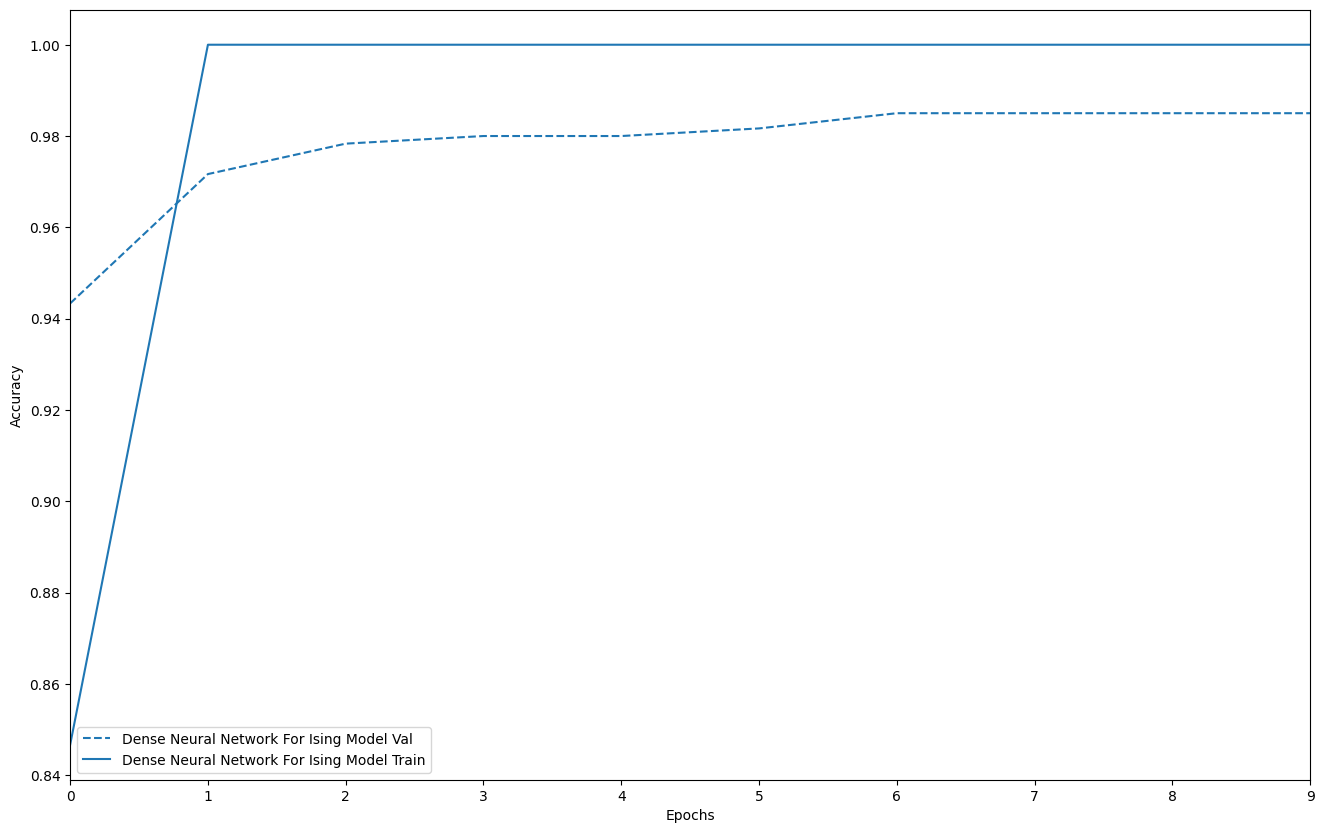

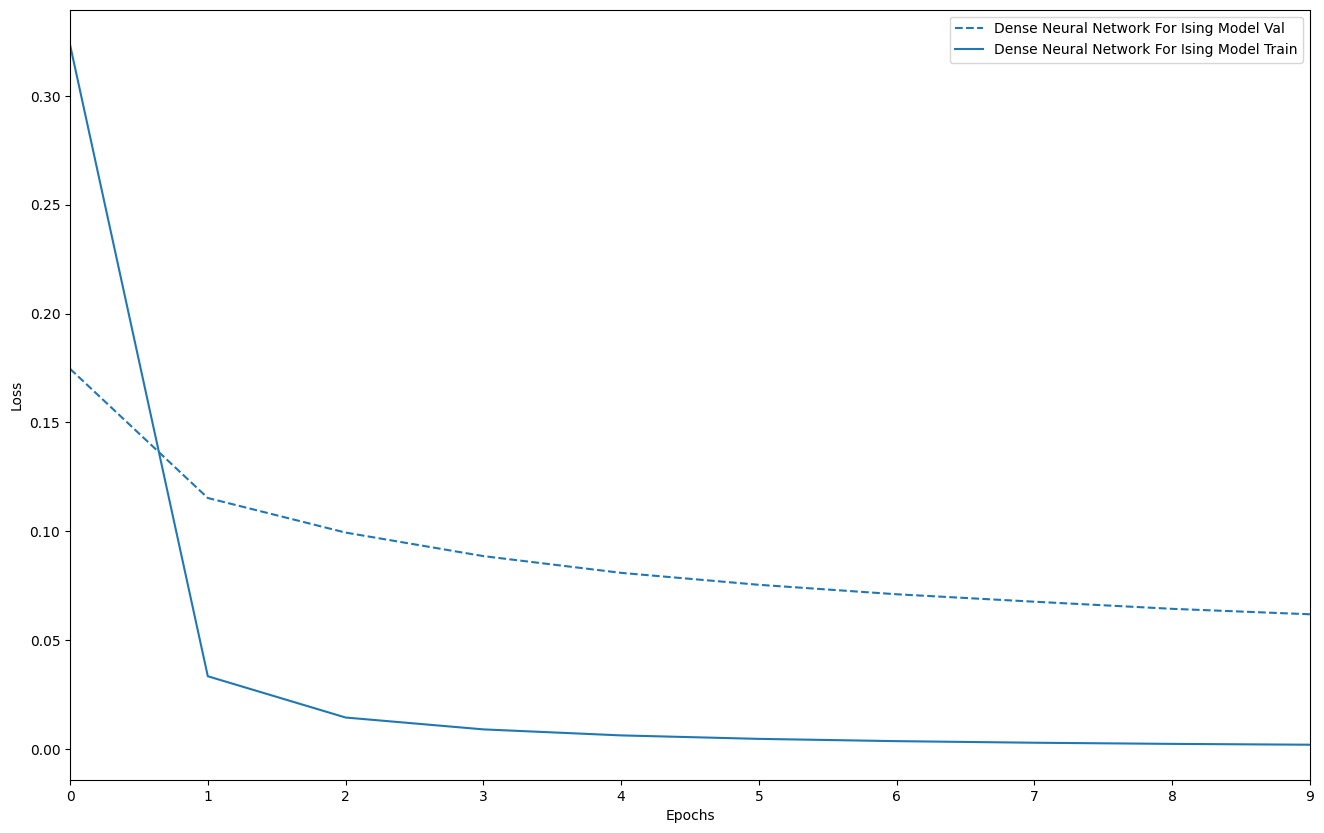

In [11]:
# See how the training looked like:
print(ising_dense_history.history.keys())
# summarize history for accuracy
plot_history([('Dense Neural Network for Ising model', ising_dense_history)], 'accuracy')
# summarize history for loss function value
plot_history([('Dense Neural Network for Ising model', ising_dense_history)], 'loss')

### Can you tell something out of these plots?

## Step 5. Evaluate our model
Now that our model is trained, we can test our model on the configurations we have not yet seen (ising_test_configs). 

In [12]:
loss, acc = model.evaluate(test_images, test_labels)

print('loss on test set =', loss)
print('accuracy on test set =', acc)

19/19 [==============================] - 0s 1ms/step - loss: 0.0618 - accuracy: 0.9850
loss on test set = 0.06184715777635574
accuracy on test set = 0.9850000143051147


We can also get the output of our model on individual configurations using the predict method. We can then use this output to see where the model would predict $T_c$ to be.

In [13]:
prediction = model.predict(ising_test_configs)
print(prediction)

32/32 [==============================] - 0s 832us/step
[[9.9902648e-01 9.7343611e-04]
 [9.9954671e-01 4.5321247e-04]
 [9.9882132e-01 1.1786658e-03]
 ...
 [2.4377248e-01 7.5622755e-01]
 [2.4059878e-03 9.9759388e-01]
 [1.8849315e-02 9.8115069e-01]]


To evaluate where the model predicts $T_c$ to be, we average the prediction for all the configurations for a given temperature. 

We also calculate the absolute value of the magnetization ($m=|\sum \sigma_i|$) for comparison, since we know that this is our order parameter.

In [14]:
Temps = list(np.sort(list(set(ising_test_labels))))
NT = len(Temps)
phase1 = np.zeros(NT)
phase2 = np.zeros(NT)
points = np.zeros(NT)
m = np.zeros(NT)
lastT = 0.
for i, T in enumerate(ising_test_labels):
    j = Temps.index(T)
    phase1[j]+=prediction[i:i+1, 0][0]
    phase2[j]+=prediction[i:i+1, 1][0]
    m[j] += abs(np.mean(ising_test_configs[i]))
    points[j]+=1.

for j in range(NT):
    phase1[j] /= points[j]
    phase2[j] /= points[j]
    m[j] /= points[j]

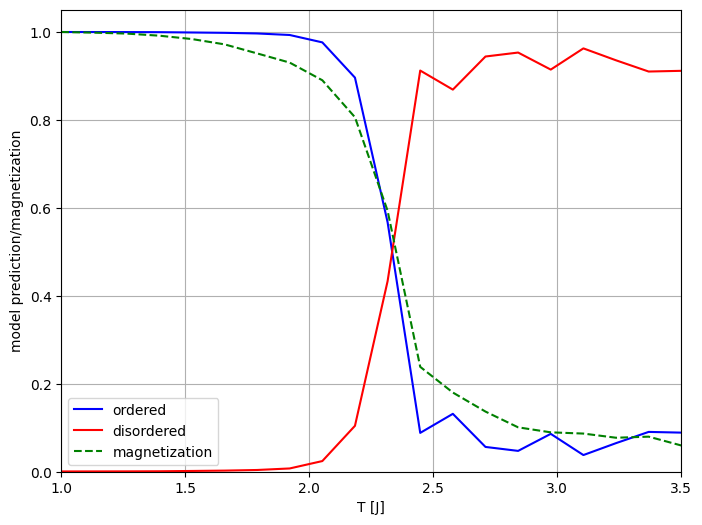

In [15]:
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(Temps, phase1, 'b', label='ordered')
plt.plot(Temps, phase2, 'r', label='disordered')
plt.plot(Temps, m, 'g--', label="magnetization")
plt.legend()
plt.ylim(0, 1.05)
plt.xlim(1,3.5)
plt.xlabel('T [J]')
plt.ylabel('model prediction/magnetization')
plt.grid()
plt.show()

We can now estimate the location of the transition. Lets define this to be the location where our model's prediction drops to  0.5 .

In [16]:
index = (np.abs(phase1 - 0.5)).argmin()
tc = Temps[index]

print("Estimated Transition Temp =", tc)

Estimated Transition Temp = 2.3157894736842106


The exact transition temperature in the thermodynamic limit is  2.2692 , so our result is not so bad considering finite size effects. If we look again at the above plot, we can see that the curves coincide relatively nicely with the average magnetization, this suggest that the network is indeed learning the magnetization, i.e. it is computing the magnetization and using it to make its prediction.